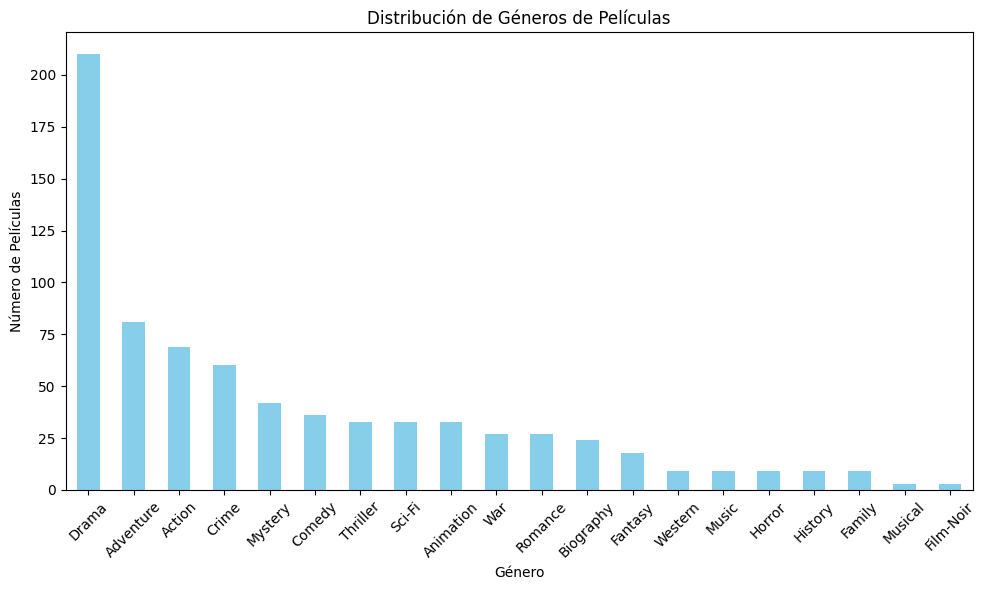

Error generating visualizations: no numeric data to plot


In [19]:
import sqlite3
import requests
from textblob import TextBlob
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Cargar variables de entorno
load_dotenv()
IMDB_API_KEY = os.getenv("IMDB_API_KEY")
OMDB_API_KEY = os.getenv("OMDB_API_KEY")

if not IMDB_API_KEY or not OMDB_API_KEY:
    raise ValueError("API keys are not set in the environment variables.")

# Conectar a la base de datos
def connect_db():
    return sqlite3.connect("movies.db")

# Crear tablas
def create_tables():
    conn = connect_db()
    try:
        cursor = conn.cursor()
        cursor.executescript('''
            CREATE TABLE IF NOT EXISTS MOVIES (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                imdb_id TEXT UNIQUE,
                rank INTEGER,
                title TEXT,
                description TEXT,
                image TEXT,
                year INTEGER,
                imdb_rating REAL,
                imdb_url TEXT
            );

            CREATE TABLE IF NOT EXISTS MOVIE_GENRES (
                movie_id INTEGER,
                genre TEXT,
                FOREIGN KEY(movie_id) REFERENCES MOVIES(id)
            );

            CREATE TABLE IF NOT EXISTS RATINGS (
                imdb_id TEXT,
                source TEXT,
                normalized_rating REAL,
                FOREIGN KEY(imdb_id) REFERENCES MOVIES(imdb_id)
            );

            CREATE TABLE IF NOT EXISTS REVIEWS (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                imdb_id TEXT,
                user_review TEXT,
                sentiment REAL,
                FOREIGN KEY(imdb_id) REFERENCES MOVIES(imdb_id)
            );
        ''')
        conn.commit()
    finally:
        conn.close()

# Obtener películas desde IMDb API
def fetch_imdb_movies():
    url = "https://imdb-top-100-movies.p.rapidapi.com/"
    headers = {
        "x-rapidapi-key": IMDB_API_KEY,
        "x-rapidapi-host": "imdb-top-100-movies.p.rapidapi.com"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching IMDb movies: {e}")
        return []

# Obtener ratings desde OMDb API
def fetch_movie_ratings(imdb_id):
    url = f"http://www.omdbapi.com/?i={imdb_id}&apikey={OMDB_API_KEY}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json().get("Ratings", [])
    except requests.RequestException as e:
        print(f"Error fetching ratings for {imdb_id}: {e}")
        return []

# Insertar película en la base de datos
def insert_movie(movie):
    conn = connect_db()
    try:
        cursor = conn.cursor()
        cursor.execute("""
            INSERT OR REPLACE INTO MOVIES (imdb_id, rank, title, description, image, year, imdb_rating, imdb_url)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            movie.get("id"),
            movie.get("rank"),
            movie.get("title", "Unknown Title"),
            movie.get("description", "No description available"),
            movie.get("image"),
            movie.get("year"),
            movie.get("imDbRating", 0.0),
            movie.get("imDbUrl", "")
        ))
        movie_id = cursor.lastrowid

        # Insertar géneros
        genres = movie.get("genre", "")
        if isinstance(genres, str):
            genres = genres.split(", ")
        elif not isinstance(genres, list):
            genres = []

        for genre in genres:
            if genre:
                cursor.execute("INSERT INTO MOVIE_GENRES (movie_id, genre) VALUES (?, ?)", (movie_id, genre))

        conn.commit()
    except KeyError as e:
        print(f"Error inserting movie: missing key {e}")
    finally:
        conn.close()

# Insertar ratings en la base de datos
def insert_ratings(imdb_id, ratings):
    if not ratings:
        return
    conn = connect_db()
    try:
        cursor = conn.cursor()
        for rating in ratings:
            source = rating.get("Source", "Unknown Source")
            value = rating.get("Value", "0/10")

            if "%" in value:
                normalized = float(value.replace("%", "")) / 10
            elif "/100" in value:
                normalized = float(value.split("/")[0]) / 10
            else:
                normalized = float(value.split("/")[0])

            cursor.execute("INSERT INTO RATINGS (imdb_id, source, normalized_rating) VALUES (?, ?, ?)", (imdb_id, source, normalized))
        conn.commit()
    except Exception as e:
        print(f"Error inserting ratings: {e}")
    finally:
        conn.close()

# Obtener y analizar reseñas (simulado)
def analyze_reviews(imdb_id):
    reviews = ["Amazing movie!", "Really boring...", "Best film ever!"]
    conn = connect_db()
    try:
        cursor = conn.cursor()
        for review in reviews:
            sentiment = TextBlob(review).sentiment.polarity
            cursor.execute("INSERT INTO REVIEWS (imdb_id, user_review, sentiment) VALUES (?, ?, ?)", (imdb_id, review, sentiment))
        conn.commit()
    except Exception as e:
        print(f"Error analyzing reviews: {e}")
    finally:
        conn.close()

# Visualizar los datos con gráficos
def generate_visualizations():
    conn = connect_db()
    try:
        # Obtener los géneros más comunes
        genres_query = "SELECT genre, COUNT(*) FROM MOVIE_GENRES GROUP BY genre ORDER BY COUNT(*) DESC"
        genres_df = pd.read_sql_query(genres_query, conn)
        genres_df.plot(kind="bar", x="genre", y="COUNT(*)", legend=False, color="skyblue", figsize=(10, 6))
        plt.title('Distribución de Géneros de Películas')
        plt.xlabel('Género')
        plt.ylabel('Número de Películas')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Obtener ratings promedio
        ratings_query = """
            SELECT MOVIES.title, AVG(RATINGS.normalized_rating) as avg_rating
            FROM MOVIES
            JOIN RATINGS ON MOVIES.imdb_id = RATINGS.imdb_id
            GROUP BY MOVIES.id
        """
        ratings_df = pd.read_sql_query(ratings_query, conn)
        ratings_df.plot(kind="bar", x="title", y="avg_rating", legend=False, color="salmon", figsize=(12, 6))
        plt.title('Ratings Promedio de las Películas')
        plt.xlabel('Película')
        plt.ylabel('Rating Promedio')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Sentimientos de las reseñas
        sentiment_query = "SELECT sentiment FROM REVIEWS"
        sentiment_df = pd.read_sql_query(sentiment_query, conn)
        sentiment_df.plot(kind="hist", bins=20, color="lightgreen", figsize=(8, 6))
        plt.title('Distribución de Sentimientos de las Reseñas')
        plt.xlabel('Sentimiento')
        plt.ylabel('Frecuencia')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating visualizations: {e}")
    finally:
        conn.close()

# Ejecutar el script
if __name__ == "__main__":
    create_tables()
    try:
        movies = fetch_imdb_movies()
        for movie in movies:
            insert_movie(movie)
            ratings = fetch_movie_ratings(movie.get("id"))
            insert_ratings(movie.get("id"), ratings)
            analyze_reviews(movie.get("id"))
    except Exception as e:
        print(f"Unexpected error: {e}")

    # Generar las visualizaciones
    generate_visualizations()